# DIST-ALERT V1 Performance Assessment

#### Import functions

In [1]:
# Import strata and sample unit information
import sys 
import math
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
source = "/gpfs/glad3/HLSDIST/Validation/LandCoverBased/analysis/Share/area-DIST-accuracy"  # Replace with the desired path
os.chdir(source)

mapsource = "mapLabels2023"
ANNname = "2023"
sampleDict = {}
sampleFull = {}
strata = {}
strataNoAlert = {}
landcoverS = {}
lossyear = {}
with open("sampledpixels_original.csv","r") as sample:
  lines = sample.readlines()[1:]
  for l in lines:
    (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
    sampleDict[ID] = ",".join([Long,Lat,zone,centxUTM,centyUTM])
    sampleFull[ID] = l.strip()
    strata[ID] = int(Stratum)
    if Stratum == "1":
      strataNoAlert[ID] = "1_"+landcover
    landcoverS[ID] = int(landcover)
    lossyear[ID] = int(forestLossYear)+2000
allIDs = sampleDict.keys()

#Strata area
strataAreas = {}
strataCounts = {}
allStrata = []
totalArea = 0
with open("stratatable_nosplit.txt","r") as file:
  lines = file.readlines()[1:]
for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  strataAreas[s] = float(area)
  strataCounts[s] = math.ceil(float(area)/(900/1000000))
  allStrata.append(int(s))
  totalArea += float(area)
Nstrata = len(strataCounts)

with open("stratatable.txt","r") as file:
  lines = file.readlines()[1:]

for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  if int(s)%5 == 1:
    landcover = str(int((int(s)-1)/5)+1)
    strataAreas["1_"+landcover] = float(area)
    strataCounts["1_"+landcover] = math.ceil(float(area)/(900/1000000))


In [2]:
def selectByLandCover(landcoverlist=[1,2,3,4,5,6,7,8,9],split1=False):
  with open("sampledpixels_original.csv","r") as sample:
    lines = sample.readlines()[1:]
    selectedIDs = []
    foundStrata = {}
    for l in lines:
      (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
      if int(landcover) in landcoverlist:
        selectedIDs.append(ID)
        if split1 and Stratum == "1":
          foundStrata[Stratum] = "1_"+landcover
        else:
          foundStrata[Stratum] = int(Stratum)
  #outdict = {key: sampleDict[key] for key in selectedIDs}
  return (selectedIDs,foundStrata.values())

#### General functions

In [3]:
def dayDiff(start,end):
  startdate = datetime.datetime.strptime(start,"%Y%m%d")
  enddate = datetime.datetime.strptime(end,"%Y%m%d")
  days = enddate-startdate
  return (days.days+1)

In [4]:
def getDISTALERTStatus_vI(skipNodata=False):
    #print(skipNodata)
    mapalert = {}
    for ID in allIDs:
        mapalert[ID] = [255 for i in range(0,366)]
        #print(ID,end=',')
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
            header = lines[0]
            maplist = lines[1:]
            for line in maplist:
                try:
                    (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
                    day = dayDiff("20230101",SensingTime)

                    if not (skipNodata and int(VEGANOM)==255):
                        if int(VEGDISTSTATUS) in [1,2,3,7] and int(VEGANOMMAX) < 10:
                            mapalert[ID][day] = 0
                        else:
                            mapalert[ID][day] = int(VEGDISTSTATUS)
                except:
                #    print(traceback)
                    print(ID,line)

    return mapalert

In [5]:
def getDISTALERTStatus_vI_GEN(skipNodata=False):
    #print(skipNodata)
    mapalert = {}
    for ID in allIDs:
        mapalert[ID] = [255 for i in range(0,366)]
        #print(ID,end=',')
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
            header = lines[0]
            maplist = lines[1:]
            for line in maplist:
                try:
                    (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
                    day = dayDiff("20230101",SensingTime)

                    if not (skipNodata and int(GENANOM)==255):
                      mapalert[ID][day] = int(GENDISTSTATUS)
                except:
                #    print(traceback)
                    print(ID,line)

    return mapalert

In [6]:
def getRefALERTbinaryDaily(filename,yeslabels,nolabels,IDlist=allIDs,conversiononly=False,only2023=False):
  if conversiononly or only2023:
    with open("reference_conversion.csv","r") as reffile:
      reflist = reffile.readlines()[1:]
    refconv = {}
    refprevyear = {}
    natural = {}
    for line in reflist:
      fields = line.strip().split(",")
      (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
      refconv[ID]=conversion
      refprevyear[ID]=prevyear
      natural[ID] = naturalproportion
  refalert = {}
  with open(filename,"r") as mapfile:
    lines = mapfile.readlines()
    header = lines[0]
    reflist = lines[1:]
  for line in reflist:
    fields = line.strip().split(",")
    (ID,overallLabel,Long,Lat,changetype) = fields[0:5]
    refalert[ID] = [0 for i in range(0,366)]
    if ID in IDlist:
      daily = fields[5:]
      #refalert[ID] = [0 for i in range(0,366)]
      try:
        for day in range(0,366):
          found = False
          for l in yeslabels:
            if l == daily[day]:
              found = True
            #if l in daily[day] and int(ID) in refVLmaj:
            #  found = True
          if found:
            refalert[ID][day] = 2
          else:
            for l in nolabels:
              if l == daily[day]:
                found = True
            if found:
              refalert[ID][day] = 1
            else:
              refalert[ID][day] = 0
          if conversiononly and (refconv[ID] != "natural" and (refconv[ID] != "human" or (refconv[ID] == "human" and natural[ID] == '0'))):#(refconv[ID] != "human" or (refconv[ID] == "human" and natural[ID] == '0')):#(refconv[ID] == "no" or natural[ID] == '0'):
            refalert[ID][day] = 0
          if only2023 and refprevyear[ID] == "TRUE":
            refalert[ID][day] = 0
      except:
        print(ID,day,daily)
  return refalert

In [7]:
def usersAccuracy(n, ntotal, name, selectedStrata=allStrata, write=True,N = strataCounts):
  #Accuracy
  y = 0
  usersx = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if ntotal[s]>0:
      y += (n[s][2][2]/ntotal[s])*N[str(s)]
      usersx += ((n[s][1][2]+n[s][2][2])/ntotal[s])*N[str(s)]
  if usersx > 0:
    users = (y/usersx)
  else:
    users = "NA"
    usersSE = "NA"

  UAsub1 = 0
  UAsub2 = 0
  if users != "NA":
    for s in selectedStrata:
      if "_" in str(s):
        stringS = s
        s = int(s.split("_")[1])
      else:
        stringS = str(s)
      if (n[s][1][2]+n[s][2][2]) > 0 and ntotal[s]>1:
        yhmean = n[s][2][2]/ntotal[s]
        yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
        xuhmean = (n[s][1][2]+n[s][2][2])/ntotal[s]
        xuhsampvar = ((n[s][1][2]+n[s][2][2])*((1-xuhmean)**2) + (n[s][1][1] + n[s][2][1])*((0-xuhmean)**2))/(ntotal[s]-1)
        xyuhsampvar = (n[s][1][1] * (0-yhmean) * (0-xuhmean) + n[s][1][2] * (0-yhmean) * (1-xuhmean) + n[s][2][1] * (0-yhmean) * (0-xuhmean) + n[s][2][2] * (1-yhmean) * (1-xuhmean))/(ntotal[s] - 1)
        UAsub1 += N[stringS]*xuhmean
        UAsub2 += N[stringS]**2 * (1 - ntotal[s]/N[stringS]) * (yhsampvar + (users**2)*xuhsampvar - 2*users*xyuhsampvar)/ntotal[s]
  
  if users != "NA":
    if UAsub1>0 and UAsub2>0:
        usersSE = math.sqrt(1/(UAsub1**2) * UAsub2) * 100
    else:
        usersSE = math.nan
    users = users*100
  else:
    users = math.nan
    usersSE = math.nan
  return [users,usersSE]


In [8]:
def producersAccuracy(n, ntotal, name, selectedStrata=allStrata, write=True,N = strataCounts):
  #Accuracy
  y = 0
  producersx = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if ntotal[s]>0:
      y += (n[s][2][2]/ntotal[s])*N[str(s)]
      producersx += ((n[s][2][1]+n[s][2][2])/ntotal[s])*N[stringS]
  #print(y,producersx)
  if producersx > 0:
    producers = (y/producersx)
  else:
    producers = "NA"
    producersSE = "NA"

  PAsub1 = 0
  PAsub2 = 0
  for s in selectedStrata:
    #users and producers
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if producers != "NA":
        if (n[s][2][1]+n[s][2][2]) > 0 and ntotal[s]>1:
            yhmean = n[s][2][2]/ntotal[s]
            yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
            xphmean = (n[s][2][1]+n[s][2][2])/ntotal[s]
            xphsampvar = ((n[s][2][1]+n[s][2][2])*((1-xphmean)**2) + (n[s][1][1] + n[s][1][2])*((0-xphmean)**2))/(ntotal[s]-1)
            xyphsampvar = (n[s][1][1] * (0-yhmean) * (0-xphmean) + n[s][1][2] * (0-yhmean) * (0-xphmean) + n[s][2][1] * (0-yhmean) * (1-xphmean) + n[s][2][2] * (1-yhmean) * (1-xphmean))/(ntotal[s] - 1)
            PAsub1 += N[stringS]*xphmean
            PAsub2 += N[stringS]**2 * (1 - ntotal[s]/N[stringS]) * (yhsampvar + (producers**2)*xphsampvar - 2*producers*xyphsampvar)/ntotal[s]
  
  if producers != "NA":
    if PAsub1 >0 and PAsub2>0:
      producersSE = math.sqrt(1/(PAsub1**2) * PAsub2) * 100
    else:
      producersSE = math.nan
    producers = producers*100
  else:
    producers = math.nan
    producersSE = math.nan#"NA"

  return [producers,producersSE]

In [9]:
def getRefALERTDaily(filename,high=["VLmaj","VLtotal"],low=["VLmin"],nochange=["OCmin","OCmaj","OCtotal","noChange"],IDlist=allIDs,conversiononly=False,only2023=False):
  if conversiononly or only2023:
    with open("reference_conversion.csv","r") as reffile:
      reflist = reffile.readlines()[1:]
    refconv = {}
    refprevyear = {}
    natural = {}
    for line in reflist:
      fields = line.strip().split(",")
      (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
      refconv[ID]=conversion
      refprevyear[ID]=prevyear
      natural[ID] = naturalproportion
  refalert = {}
  with open(filename,"r") as mapfile:
    lines = mapfile.readlines()
    header = lines[0]
    reflist = lines[1:]
  for line in reflist:
    fields = line.strip().split(",")
    (ID,overallLabel,Long,Lat,changetype) = fields[0:5]
    refalert[ID] = [0 for i in range(0,366)]
    if ID in IDlist:
      daily = fields[5:]
      #refalert[ID] = [0 for i in range(0,366)]
      try:
        for day in range(0,366):
          found = False
          for l in high:
            if l == daily[day]:
              refalert[ID][day] = 3
          for l in low:
            if l == daily[day]:
              refalert[ID][day] = 2
          for l in nochange:
            if l == daily[day]:
              refalert[ID][day] = 1
          if conversiononly and (refconv[ID] != "natural" and (refconv[ID] != "human" or (refconv[ID] == "human" and natural[ID] == '0'))):#(refconv[ID] != "human" or (refconv[ID] == "human" and natural[ID] == '0')):#(refconv[ID] == "no" or natural[ID] == '0'):
            refalert[ID][day] = 0
          if only2023 and refprevyear[ID] == "TRUE":
            refalert[ID][day] = 0
      except:
        print(ID,day,daily)
  return refalert

In [10]:
def getMatrix(mapin,maplow,maphigh,nodata=[255],refType="VEG",convOnly=False,only23 =False,mincount=10,Ndays=30,selectedStrata=allStrata, IDlist=allIDs,excludelist=[],strataList=allStrata,strataDict=strata,N=strataCounts):
  mapout = {}
  n = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in strataList}
  ntotal = {s:0 for s in strataList}
  if refType == "VEG":
    ref = getRefALERTDaily("referenceTimeSeriesInterpolated16.csv",high=["VLmaj","VLtotal"],low=["VLmin"],nochange=["OCmin","OCmaj","OCtotal","noChange"],conversiononly=convOnly,only2023=only23)
  elif refType =="OCVL":
    ref = getRefALERTDaily("referenceTimeSeriesInterpolated16.csv",high=["VLmaj","VLtotal","OCmaj","OCtotal"],low=["VLmin","OCmin"],nochange=["noChange"],conversiononly=convOnly,only2023=only23)
  elif refType =="OConly":
    ref = getRefALERTDaily("referenceTimeSeriesInterpolated16.csv",high=["OCmaj","OCtotal"],low=["OCmin"],nochange=["noChange"],conversiononly=convOnly,only2023=only23)
  elif refType == "OConly_VLvalid":
    ref = getRefALERTDaily("referenceTimeSeriesInterpolated16.csv",high=["OCmaj","OCtotal"],low=["OCmin"],nochange=["noChange","VLmin","VLmaj","VLtotal"],conversiononly=convOnly,only2023=only23)

  #confusion matrix
  for ID in IDlist:
    try:
      p = [[0,0,0],[0,0,0],[0,0,0]]
      ptotal = 0
      mapout[ID] = [0 for x in range(0,366)]
      for d in range(0,366):
        if mapin[ID][d] in [255] or mapin[ID][d] in nodata:#4 first excluded
            mapout[ID][d] = 0
        elif mapin[ID][d] in [0]:
            mapout[ID][d] = 1
        elif mapin[ID][d] in maplow:#[2,3,7]: #1 first excluded  
            mapout[ID][d] = 2
        elif mapin[ID][d] in maphigh:#[5,6,8]:#4 first excluded
            mapout[ID][d] = 3
        else:############added to exclude fron natrix but include in proportion
            mapout[ID][d] = 4
        if not int(ID) in excludelist:
          if max(ref[ID][0:(d+1)])>0 and mapout[ID][d] != 0:
              start = (d>Ndays)*(d-Ndays)
              if mapin[ID][d] < 7:
                  if ref[ID][start:(d+mincount)].count(2)+ref[ID][start:(d+mincount)].count(3) > mincount:
                    if ref[ID][start:(d+mincount)].count(3) > 0:
                      refVal=3
                    else:
                      refVal=2
                  elif ref[ID][start:(d+1)].count(1) > 0:
                      refVal=1
                  else:
                      refVal=0
              elif mapin[ID][d] >= 7 and mapin[ID][d]!=255:
                  start = 0
                  if ref[ID][start:(d+mincount)].count(2)+ref[ID][start:(d+mincount)].count(3) > mincount:
                    if ref[ID][start:(d+mincount)].count(3) > 0:
                      refVal=3
                    else:
                      refVal=2
                  elif ref[ID][start:(d+1)].count(1) > 0:
                      refVal=1
                  else:
                      refVal=0
              else:
                refVal=0
              mapVal = mapout[ID][d]
              if mapVal==4 and refVal>0:
                ptotal += 1
              elif refVal>0 and mapVal>0:
                  p[refVal-1][mapVal-1] += 1
                  ptotal += 1
      if ptotal>0:
        #if p[1][2] >0 or p[2][1] >0:  
        #  with open(name+".txt","a") as OUT:
        #    OUT.write(str(ID)+","+str(p[1][1])+","+str(p[1][2])+","+str(p[2][1])+","+str(p[2][2])+","+str(ptotal)+"\n")
        ntotal[strataDict[ID]] += 1
        for r in [0,1,2]:
          for m in [0,1,2]:
            n[strataDict[ID]][r][m] += (p[r][m]/ptotal)
    except:
      print(ID,"missing",strataDict[ID],d,p,ptotal,ntotal[strataDict[ID]])
      print(mapin[ID])
      print(ref[ID])
  
  #conf Matrix
  nout = [[0,0,0],[0,0,0],[0,0,0]]
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if ntotal[s]>0:
      for r in range(0,3):
        for c in range(0,3):
          nout[r][c] += (n[s][r][c]/ntotal[s])*N[str(s)]
  #print(nout)
  return (n,ntotal, nout)

In [11]:
def convMat(n,selectedStrata=allStrata):
  nlowuser = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in selectedStrata}
  nlowprod = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in selectedStrata}
  nhiuser = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in selectedStrata}
  nhiprod = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in selectedStrata}
  nalluser = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in selectedStrata}
  nallprod = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in selectedStrata}
  NO = 0
  LOW = 1
  HI = 2
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    #[ref][map]
    nlowprod[s][2][2] = n[s][LOW][LOW] + n[s][LOW][HI]
    nlowprod[s][2][1] = n[s][LOW][NO]
    nlowuser[s][2][2] = n[s][LOW][LOW] + n[s][HI][LOW]
    nlowuser[s][1][2] = n[s][NO][LOW]

    nhiprod[s][2][2] = n[s][HI][HI] + n[s][HI][LOW]
    nhiprod[s][2][1] = n[s][HI][NO]
    nhiuser[s][2][2] = n[s][HI][HI] + n[s][LOW][HI]
    nhiuser[s][1][2] = n[s][NO][HI]

    nallprod[s][2][2] = n[s][HI][HI] + n[s][HI][LOW] + n[s][LOW][HI] + n[s][LOW][LOW]
    nallprod[s][2][1] = n[s][HI][NO] + n[s][LOW][NO]
    nalluser[s][2][2] = n[s][HI][HI] + n[s][LOW][HI] + n[s][HI][LOW] + n[s][LOW][LOW]
    nalluser[s][1][2] = n[s][NO][HI] + n[s][NO][LOW]
  return (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod)

In [12]:
def getAccuracies(n,ntotal, name,measure="both"):
  (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod) = convMat(n)
  loU="NA"
  loUSE="NA"
  loP="NA"
  loPSE="NA"
  hiU="NA"
  hiUSE="NA"
  hiP="NA"
  hiPSE="NA"
  aU="NA"
  aUSE="NA"
  aP="NA"
  aPSE="NA"
  if measure =="both" or measure == "users":
    (loU,loUSE) = usersAccuracy(nlowuser, ntotal, "",allStrata)
    (hiU,hiUSE) = usersAccuracy(nhiuser, ntotal, "",allStrata)
    (aU,aUSE) = usersAccuracy(nalluser, ntotal, "",allStrata)
  if measure =="both" or measure =="producers":
    (loP,loPSE) = producersAccuracy(nlowprod, ntotal, "",allStrata)
    (hiP,hiPSE) = producersAccuracy(nhiprod, ntotal, "",allStrata)
    (aP,aPSE) = producersAccuracy(nallprod, ntotal, "",allStrata)
  return [[name+"_low",loU,loUSE,loP,loPSE],[name+"_high",hiU,hiUSE,hiP,hiPSE],[name+"_all",aU,aUSE,aP,aPSE]]

## Accuracy for all land cover combined and original land cover strata

#### Calculate VEG accuracy

In [13]:
map = getDISTALERTStatus_vI(True)

1323 OPERA_L3_DIST-ALERT-HLS_T19HFC_20230219T142709Z_20231221T042133Z_S2B_30_v1_VEG-DIST-STATUS,20230219,2023-12-21 04:21:33,,,,,,


In [14]:
print("Accuracy of VEG for detecting vegetation loss for all strata combined (Users SE Producers SE)")

accuracies = []
(n,ntotal,nout)=getMatrix(map,[2],[5],nodata=[1,3,7,4,6,8])
accuracies = accuracies + getAccuracies(n,ntotal, "prov",measure="users")

(n,ntotal,nout)=getMatrix(map,[2,3,7],[5,6,8],nodata=[1,4])
accuracies = accuracies + getAccuracies(n,ntotal, "provconf")

(n,ntotal,nout)=getMatrix(map,[3,7],[6,8],nodata=[1,2,4,5])
accuracies = accuracies + getAccuracies(n,ntotal, "conf")

(n,ntotal,nout)=getMatrix(map,[2,3,7],[5,6,8],nodata=[1,4],convOnly=True,only23=True)
accuracies = accuracies + getAccuracies(n,ntotal, "conversion",measure="producers")

accuracies = pd.DataFrame(accuracies,columns=["name","users","usersSE","producers","producersSE"])
accuracies = accuracies[["users","usersSE","producers","producersSE"]].set_index(accuracies.name)
print(accuracies)


Accuracy of VEG for detecting vegetation loss for all strata combined (Users SE Producers SE)
                   users  usersSE producers producersSE
name                                                   
prov_low         66.3482  8.10375        NA          NA
prov_high        77.9155  10.2764        NA          NA
prov_all         67.0954  7.61893        NA          NA
provconf_low     78.7635  5.43338     55.91     6.00772
provconf_high     92.327  2.81386   94.1808     5.43214
provconf_all     81.4884  4.39151   62.1086     5.35459
conf_low         89.3908  4.48585   50.0344     6.09763
conf_high        94.1639  2.52674   93.8746     5.59043
conf_all         90.6131  3.39957   57.4026     5.47083
conversion_low        NA       NA   67.7299     25.1019
conversion_high       NA       NA   99.2539     1.53734
conversion_all        NA       NA   74.2088     20.4779


In [15]:
mapsource = "mapLabels2023"
land = {1:"builtup",2:"treestable",3:"treedisturb",4:"crop",5:"wetland",6:"hishortveg",7:"lowshortveg",8:"other"}
Adict = {}
U= {}
USE = {}
P = {}
PSE = {}

duration = 10
lookback = 30
#provconf
cat="provconf"
name = "_lookback"+str(lookback)+"_duration"+str(duration)
U[cat+"low"]=[]
USE[cat+"low"]=[]
U[cat+"high"]=[]
USE[cat+"high"]=[]
U[cat+"all"]=[]
USE[cat+"all"]=[]
P[cat+"low"]=[]
PSE[cat+"low"]=[]
P[cat+"high"]=[]
PSE[cat+"high"]=[]
P[cat+"all"]=[]
PSE[cat+"all"]=[]
for lc in [[1],[2],[3],[4],[5],[6],[7],[8],"all"]:
  if lc == "all":
    (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
  else:
    (selectedIDs,selectedStrata) = selectByLandCover(lc,True)
  (n,ntotal,nout)=getMatrix(map,[2,3,7],[5,6,8],nodata=[1,4],mincount=duration,Ndays=lookback)
  (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod) = convMat(n)
  (loP,loPSE) = producersAccuracy(nlowprod, ntotal, "",selectedStrata)
  (loU,loUSE) = usersAccuracy(nlowuser, ntotal, "",selectedStrata)
  (hiP,hiPSE) = producersAccuracy(nhiprod, ntotal, "",selectedStrata)
  (hiU,hiUSE) = usersAccuracy(nhiuser, ntotal, "",selectedStrata)
  (aP,aPSE) = producersAccuracy(nallprod, ntotal, "",selectedStrata)
  (aU,aUSE) = usersAccuracy(nalluser, ntotal, "",selectedStrata)
  U[cat+"low"].append(loU)
  USE[cat+"low"].append(loUSE)
  U[cat+"high"].append(hiU)
  USE[cat+"high"].append(hiUSE)
  U[cat+"all"].append(aU)
  USE[cat+"all"].append(aUSE)
  P[cat+"low"].append(loP)
  PSE[cat+"low"].append(loPSE)
  P[cat+"high"].append(hiP)
  PSE[cat+"high"].append(hiPSE)
  P[cat+"all"].append(aP)
  PSE[cat+"all"].append(aPSE)

cat = "conf"
U[cat+"low"]=[]
USE[cat+"low"]=[]
U[cat+"high"]=[]
USE[cat+"high"]=[]
U[cat+"all"]=[]
USE[cat+"all"]=[]
P[cat+"low"]=[]
PSE[cat+"low"]=[]
P[cat+"high"]=[]
PSE[cat+"high"]=[]
P[cat+"all"]=[]
PSE[cat+"all"]=[]
for lc in [[1],[2],[3],[4],[5],[6],[7],[8],"all"]:
  if lc == "all":
    (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
  else:
    (selectedIDs,selectedStrata) = selectByLandCover(lc,True)
  (n,ntotal,nout)=getMatrix(map,[3,7],[6,8],nodata=[1,2,4,5],mincount=duration,Ndays=lookback)
  (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod) = convMat(n)
  (loP,loPSE) = producersAccuracy(nlowprod, ntotal, "",selectedStrata)
  (loU,loUSE) = usersAccuracy(nlowuser, ntotal, "",selectedStrata)
  (hiP,hiPSE) = producersAccuracy(nhiprod, ntotal, "",selectedStrata)
  (hiU,hiUSE) = usersAccuracy(nhiuser, ntotal, "",selectedStrata)
  (aP,aPSE) = producersAccuracy(nallprod, ntotal, "",selectedStrata)
  (aU,aUSE) = usersAccuracy(nalluser, ntotal, "",selectedStrata)
  U[cat+"low"].append(loU)
  USE[cat+"low"].append(loUSE)
  U[cat+"high"].append(hiU)
  USE[cat+"high"].append(hiUSE)
  U[cat+"all"].append(aU)
  USE[cat+"all"].append(aUSE)
  P[cat+"low"].append(loP)
  PSE[cat+"low"].append(loPSE)
  P[cat+"high"].append(hiP)
  PSE[cat+"high"].append(hiPSE)
  P[cat+"all"].append(aP)
  PSE[cat+"all"].append(aPSE)


#### Plot accuracy of each land cover strata

     landcover    users  usersSE usersconf usersconfSE     prod   prodSE  \
0      Builtup   83.656  10.4941   99.9655    0.175565  63.9374  12.8467   
1   treestable  77.8303  13.4849   83.9272      14.863  31.9845  15.9933   
2  treedisturb  85.1796  8.18709   87.0481     9.10053  59.5167  10.3091   
3         crop  84.7775  8.57903   97.4395     1.57384  25.2461  11.3172   
4      wetland  74.3293   9.0341   83.4976     7.34915  16.9375  15.9201   
5   hishortveg  72.5888  13.2315   87.8454     10.9145  39.7446  15.3852   
6  lowshortveg  82.8545  11.4386   89.0176     10.4937  31.8397  13.0899   
7        other  75.1391  14.2917   81.1869     15.8091  4.34663  19.9537   
8          all  78.7635  5.43338   89.3908     4.48585    55.91  6.00772   

  prodconf prodconfSE  
0  56.7315    13.4641  
1  22.3013    13.1112  
2  49.3998    10.7739  
3  23.9775    11.6942  
4  16.6215    16.2314  
5  34.4643    14.8881  
6  28.9483    12.5208  
7  3.16473    19.0124  
8  50.0344    6.09763  

/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Text(0.5,1,'All loss alerts')

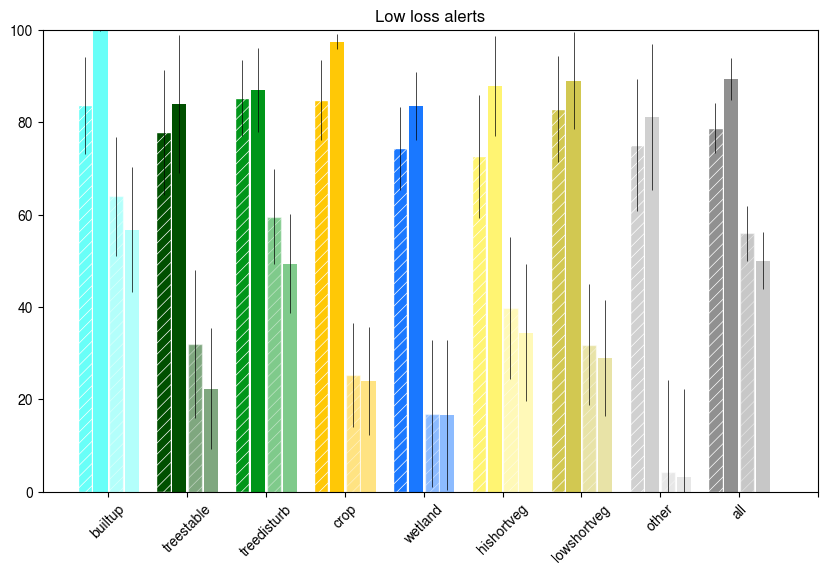

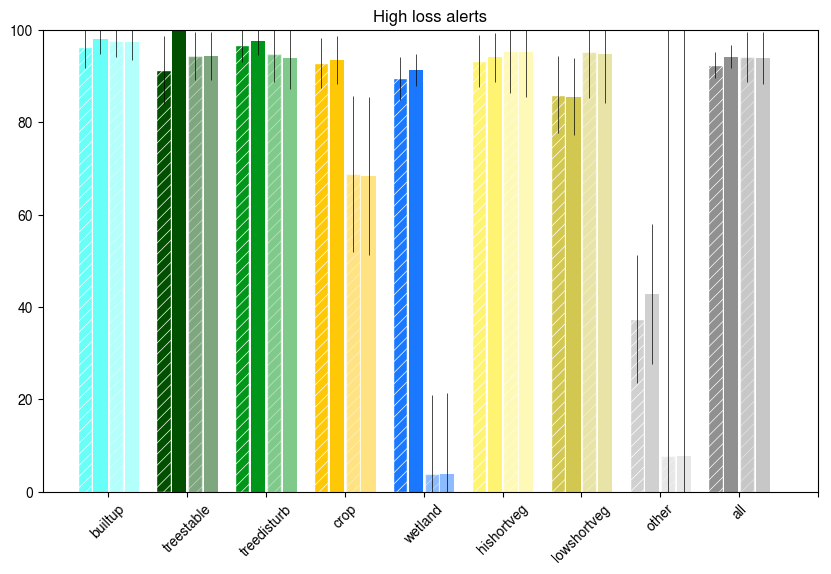

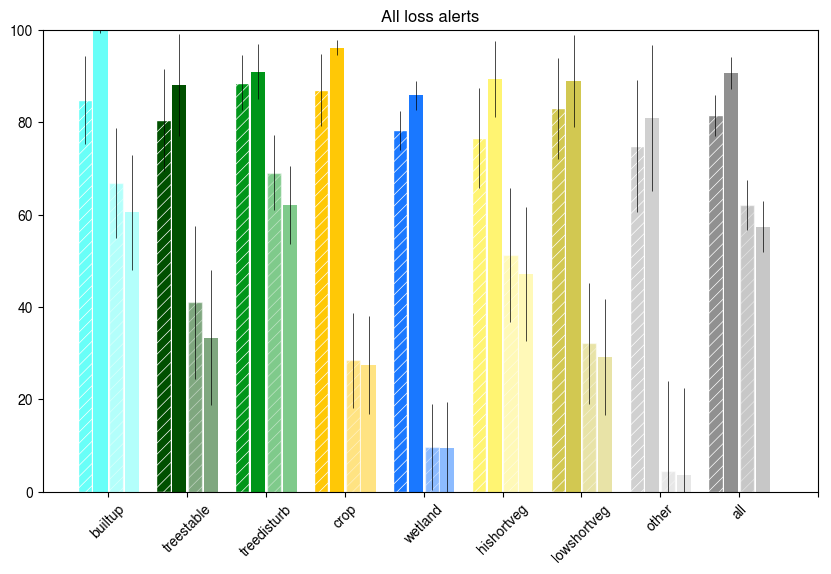

In [16]:
#accuracy 
import pandas as pd
import matplotlib
matplotlib.style.use('default')

dfU = pd.DataFrame(U.values())
dfUSE = pd.DataFrame(USE.values())
dfP = pd.DataFrame(P.values())
dfPSE = pd.DataFrame(PSE.values())

df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"],
                   U["provconflow"],
                   USE["provconflow"],
                   U["conflow"],
                   USE["conflow"],
                   P["provconflow"],
                   PSE["provconflow"],
                   P["conflow"],
                   PSE["conflow"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersSE","usersconf","usersconfSE","prod","prodSE","prodconf","prodconfSE"]
print(df)
strats = ["builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"]#"water"
#print(df["userslt50"])
x = np.arange(len(strats))
width=0.2
#print(x)

fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['hatch.linewidth'] = 0.5
palette = ["#68fff8","#005000","#009619","#ffc806","#1A78FF","#fff472","#d2c851","#d0d0d0","#909090"]
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=df["usersSE"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=df["usersconfSE"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=df["prodSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=df["prodconfSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("Low loss alerts")
fig.show()

df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"],
                   U["provconfhigh"],
                   USE["provconfhigh"],
                   U["confhigh"],
                   USE["confhigh"],
                   P["provconfhigh"],
                   PSE["provconfhigh"],
                   P["confhigh"],
                   PSE["confhigh"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersSE","usersconf","usersconfSE","prod","prodSE","prodconf","prodconfSE"]
print(df)
strats = ["builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"]#"water"
x = np.arange(len(strats))
width=0.2


fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=df["usersSE"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=df["usersconfSE"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=df["prodSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=df["prodconfSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("High loss alerts")


df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"],
                   U["provconfall"],
                   USE["provconfall"],
                   U["confall"],
                   USE["confall"],
                   P["provconfall"],
                   PSE["provconfall"],
                   P["confall"],
                   PSE["confall"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersSE","usersconf","usersconfSE","prod","prodSE","prodconf","prodconfSE"]
print(df)
x = np.arange(len(strats))
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=df["usersSE"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=df["usersconfSE"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=df["prodSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=df["prodconfSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("All loss alerts")


#### Conversion

/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


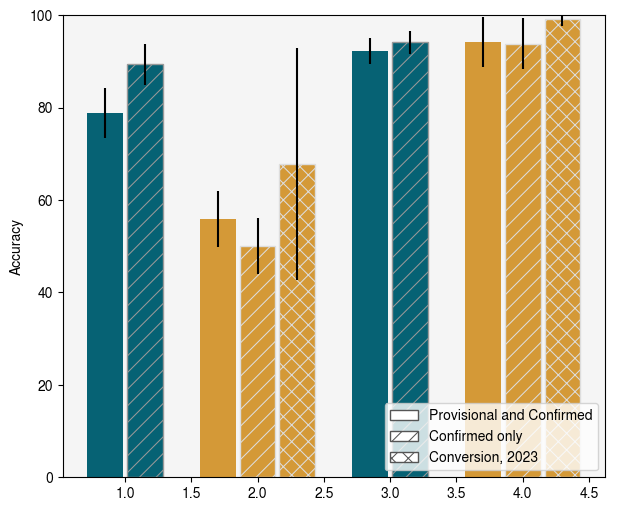

In [17]:
fig, ax = plt.subplots(figsize=(7,6))
plt.grid(False)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['hatch.linewidth'] = 0.75
pal = ["#066274","#D49937"]
pal = [pal[0],pal[0],pal[1],pal[1],pal[0],pal[0],pal[1],pal[1]]
width =0.3
ax.bar(1-width/2,accuracies.at["provconf_low",'users'],width-width*0.1,yerr=accuracies.at["provconf_low",'usersSE'],color=pal[0],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(1+width/2,accuracies.at["conf_low",'users'],width-width*0.1,yerr=accuracies.at["conf_low",'usersSE'],color=pal[1],error_kw=dict(lw=1.5),hatch='//',edgecolor="#999999")
#ax.bar(1+width,df["val"][2],width-width*0.1,yerr=df["SE"][2],color=pal[1],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#999999")
ax.bar(2-width,accuracies.at["provconf_low",'producers'],width-width*0.1,yerr=accuracies.at["provconf_low",'producersSE'],color=pal[2],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(2,accuracies.at["conf_low",'producers'],width-width*0.1,yerr=accuracies.at["conf_low",'producersSE'],color=pal[3],error_kw=dict(lw=1.5),hatch='//',edgecolor="#dddddd")
ax.bar(2+width,accuracies.at["conversion_low",'producers'],width-width*0.1,yerr=accuracies.at["conversion_low",'producersSE'],color=pal[3],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#dddddd")
ax.bar(3-width/2,accuracies.at["provconf_high",'users'],width-width*0.1,yerr=accuracies.at["provconf_high",'usersSE'],color=pal[4],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(3+width/2,accuracies.at["conf_high",'users'],width-width*0.1,yerr=accuracies.at["conf_high",'usersSE'],color=pal[5],error_kw=dict(lw=1.5),hatch='//',edgecolor="#999999")
#ax.bar(3+width,df["val"][8],width-width*0.1,yerr=df["SE"][8],color=pal[5],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#999999")
ax.bar(4-width,accuracies.at["provconf_high",'producers'],width-width*0.1,yerr=accuracies.at["provconf_high",'producersSE'],color=pal[6],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(4,accuracies.at["conf_high",'producers'],width-width*0.1,yerr=accuracies.at["conf_high",'producersSE'],color=pal[7],error_kw=dict(lw=1.5),hatch='//',edgecolor="#dddddd")
ax.bar(4+width,accuracies.at["conversion_high",'producers'],width-width*0.1,yerr=accuracies.at["conversion_high",'producersSE'],color=pal[7],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#dddddd")
ax.set_ylim([0, 100])
ax.set_facecolor("#f5f5f5")
ax.set_ylabel("Accuracy")

import matplotlib.patches as mpatches
all = mpatches.Patch(facecolor='#ffffff', label='Provisional and Confirmed',edgecolor="#555555")
conf = mpatches.Patch(facecolor='#ffffff', label='Confirmed only',hatch='//',edgecolor="#555555")
conv = mpatches.Patch(facecolor='#ffffff', label='Conversion, 2023',hatch='xx',edgecolor="#555555")
ax.legend(handles=[all,conf,conv],loc="lower right")

plt.savefig("accuracy.svg",bbox_inches='tight')
fig.show()

## Accuracy for land cover strata plus water

#### Import functions

In [18]:
# Import strata and sample unit information
mapsource = "mapLabels2023"
ANNname = "2023"
sampleFullW = {}
strataW = {}
strataNoAlertW = {}
landcoverSW = {}
lossyear = {}
with open("sampledpixels_water.csv","r") as sample:
  lines = sample.readlines()[1:]
  for l in lines:
    (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
    sampleFullW[ID] = l.strip()
    strataW[ID] = int(Stratum)
    if Stratum == "1":
      strataNoAlertW[ID] = "1_"+landcover
    landcoverSW[ID] = int(landcover)
    lossyear[ID] = int(forestLossYear)+2000

#Strata area
strataAreasW = {}
strataCountsW = {}
allStrataW = []
totalAreaW = 0
with open("stratatable_water_nosplit.txt","r") as file:
  lines = file.readlines()[1:]
for l in lines:
  (s,count,area,K) = l.strip().split("\t")
  strataAreasW[s] = float(area)
  strataCountsW[s] = math.ceil(float(area)/(900/1000000))
  allStrataW.append(int(s))
  totalAreaW += float(area)
Nstrata = len(strataCounts)

with open("stratatable_water.txt","r") as file:
  lines = file.readlines()[1:]

for l in lines:
  (s,count,area,K) = l.strip().split("\t")
  if int(s)%5 == 1:
    landcover = str(int((int(s)-1)/5)+1)
    strataAreasW["1_"+landcover] = float(area)
    strataCountsW["1_"+landcover] = math.ceil(float(area)/(900/1000000))


In [19]:
def selectByLandCoverWater(landcoverlist=[1,2,3,4,5,6,7,8,9],split1=False):
  with open("sampledpixels_water.csv","r") as sample:
    lines = sample.readlines()[1:]
    selectedIDs = []
    foundStrata = {}
    for l in lines:
      (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
      if int(landcover) in landcoverlist:
        selectedIDs.append(ID)
        if split1 and Stratum == "1":
          foundStrata[Stratum] = "1_"+landcover
        else:
          foundStrata[Stratum] = int(Stratum)
  return (selectedIDs,foundStrata.values())

#### Accuracy per land cover stratum

In [20]:
mapsource = "mapLabels2023"
land = {1:"builtup",2:"treestable",3:"treedisturb",4:"crop",5:"wetland",6:"hishortveg",7:"lowshortveg",8:"other"}
Adict = {}
U= {}
USE = {}
P = {}
PSE = {}

duration = 10
lookback = 30
#provconf
cat="provconf"
name = "_lookback"+str(lookback)+"_duration"+str(duration)
U[cat+"low"]=[]
USE[cat+"low"]=[]
U[cat+"high"]=[]
USE[cat+"high"]=[]
U[cat+"all"]=[]
USE[cat+"all"]=[]
P[cat+"low"]=[]
PSE[cat+"low"]=[]
P[cat+"high"]=[]
PSE[cat+"high"]=[]
P[cat+"all"]=[]
PSE[cat+"all"]=[]
for lc in [[1],[2],[3],[4],[5],[6],[7],[8],[9],"all"]:
  if lc == "all":
    (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
    (n,ntotal,nout)=getMatrix(map,[2,3,7],[5,6,8],nodata=[1,4],mincount=duration,Ndays=lookback)
    (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod) = convMat(n)
    (loP,loPSE) = producersAccuracy(nlowprod, ntotal, "",selectedStrata)
    (loU,loUSE) = usersAccuracy(nlowuser, ntotal, "",selectedStrata)
    (hiP,hiPSE) = producersAccuracy(nhiprod, ntotal, "",selectedStrata)
    (hiU,hiUSE) = usersAccuracy(nhiuser, ntotal, "",selectedStrata)
    (aP,aPSE) = producersAccuracy(nallprod, ntotal, "",selectedStrata)
    (aU,aUSE) = usersAccuracy(nalluser, ntotal, "",selectedStrata)
  else:
    (selectedIDs,selectedStrata) = selectByLandCoverWater(lc,True)
    (n,ntotal,nout)=getMatrix(map,[2,3,7],[5,6,8],nodata=[1,4],mincount=duration,Ndays=lookback,selectedStrata=selectedStrata, IDlist=selectedIDs,strataList=allStrataW,strataDict=strataW,N=strataCountsW)
    (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod) = convMat(n,allStrataW)
    (loP,loPSE) = producersAccuracy(nlowprod, ntotal, "",selectedStrata,N=strataCountsW)
    (loU,loUSE) = usersAccuracy(nlowuser, ntotal, "",selectedStrata,N=strataCountsW)
    (hiP,hiPSE) = producersAccuracy(nhiprod, ntotal, "",selectedStrata,N=strataCountsW)
    (hiU,hiUSE) = usersAccuracy(nhiuser, ntotal, "",selectedStrata,N=strataCountsW)
    (aP,aPSE) = producersAccuracy(nallprod, ntotal, "",selectedStrata,N=strataCountsW)
    (aU,aUSE) = usersAccuracy(nalluser, ntotal, "",selectedStrata,N=strataCountsW)
  U[cat+"low"].append(loU)
  USE[cat+"low"].append(loUSE)
  U[cat+"high"].append(hiU)
  USE[cat+"high"].append(hiUSE)
  U[cat+"all"].append(aU)
  USE[cat+"all"].append(aUSE)
  P[cat+"low"].append(loP)
  PSE[cat+"low"].append(loPSE)
  P[cat+"high"].append(hiP)
  PSE[cat+"high"].append(hiPSE)
  P[cat+"all"].append(aP)
  PSE[cat+"all"].append(aPSE)

cat = "conf"
U[cat+"low"]=[]
USE[cat+"low"]=[]
U[cat+"high"]=[]
USE[cat+"high"]=[]
U[cat+"all"]=[]
USE[cat+"all"]=[]
P[cat+"low"]=[]
PSE[cat+"low"]=[]
P[cat+"high"]=[]
PSE[cat+"high"]=[]
P[cat+"all"]=[]
PSE[cat+"all"]=[]
for lc in [[1],[2],[3],[4],[5],[6],[7],[8],[9],"all"]:
  if lc == "all":
    (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
    (n,ntotal,nout)=getMatrix(map,[3,7],[6,8],nodata=[1,2,4,5],refType="VEG",convOnly=False,only23 =False,mincount=duration,Ndays=lookback)
    (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod) = convMat(n)
    (loP,loPSE) = producersAccuracy(nlowprod, ntotal, "",selectedStrata)
    (loU,loUSE) = usersAccuracy(nlowuser, ntotal, "",selectedStrata)
    (hiP,hiPSE) = producersAccuracy(nhiprod, ntotal, "",selectedStrata)
    (hiU,hiUSE) = usersAccuracy(nhiuser, ntotal, "",selectedStrata)
    (aP,aPSE) = producersAccuracy(nallprod, ntotal, "",selectedStrata)
    (aU,aUSE) = usersAccuracy(nalluser, ntotal, "",selectedStrata)
  else:
    (selectedIDs,selectedStrata) = selectByLandCoverWater(lc,True)
    (n,ntotal,nout)=getMatrix(map,[3,7],[6,8],nodata=[1,2,4,5],mincount=duration,Ndays=lookback,selectedStrata=selectedStrata, IDlist=selectedIDs,strataList=allStrataW,strataDict=strataW,N=strataCountsW)
    (nlowuser, nlowprod, nhiuser, nhiprod,nalluser, nallprod) = convMat(n,allStrataW)
    (loP,loPSE) = producersAccuracy(nlowprod, ntotal, "",selectedStrata,N=strataCountsW)
    (loU,loUSE) = usersAccuracy(nlowuser, ntotal, "",selectedStrata,N=strataCountsW)
    (hiP,hiPSE) = producersAccuracy(nhiprod, ntotal, "",selectedStrata,N=strataCountsW)
    (hiU,hiUSE) = usersAccuracy(nhiuser, ntotal, "",selectedStrata,N=strataCountsW)
    (aP,aPSE) = producersAccuracy(nallprod, ntotal, "",selectedStrata,N=strataCountsW)
    (aU,aUSE) = usersAccuracy(nalluser, ntotal, "",selectedStrata,N=strataCountsW)
  U[cat+"low"].append(loU)
  USE[cat+"low"].append(loUSE)
  U[cat+"high"].append(hiU)
  USE[cat+"high"].append(hiUSE)
  U[cat+"all"].append(aU)
  USE[cat+"all"].append(aUSE)
  P[cat+"low"].append(loP)
  PSE[cat+"low"].append(loPSE)
  P[cat+"high"].append(hiP)
  PSE[cat+"high"].append(hiPSE)
  P[cat+"all"].append(aP)
  PSE[cat+"all"].append(aPSE)

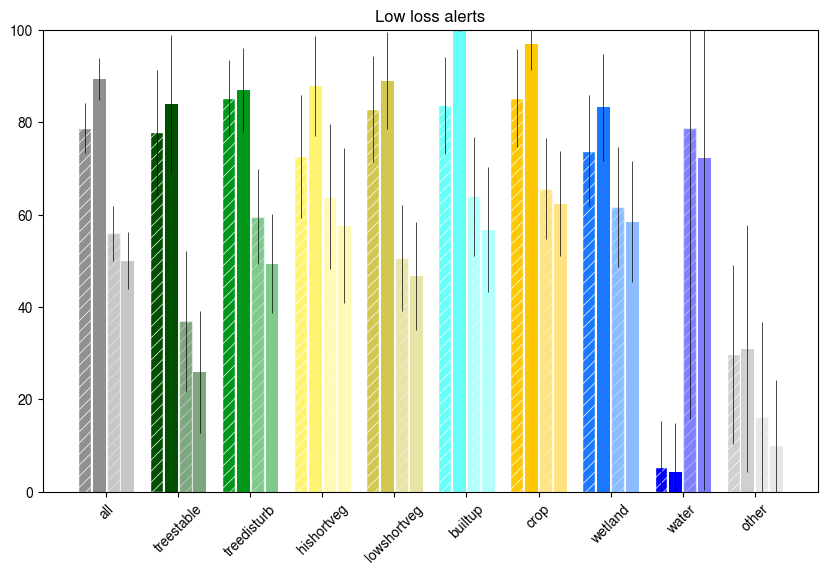

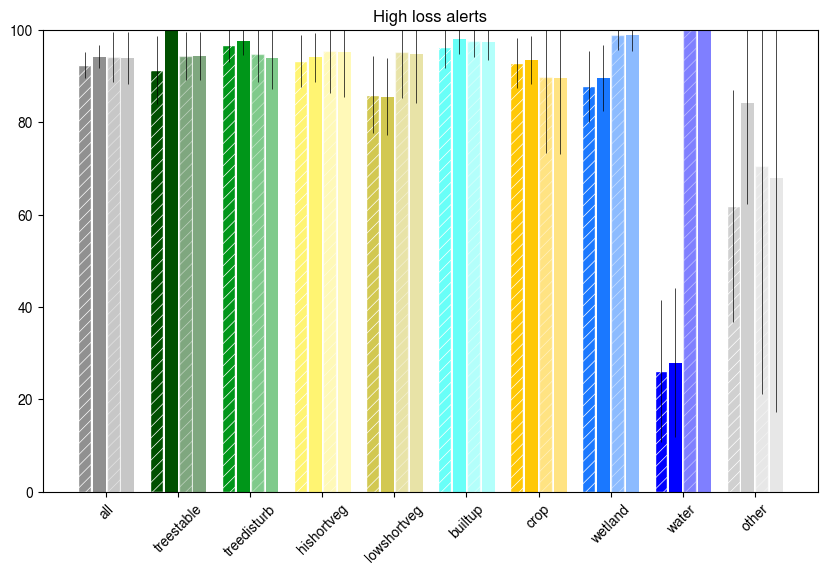

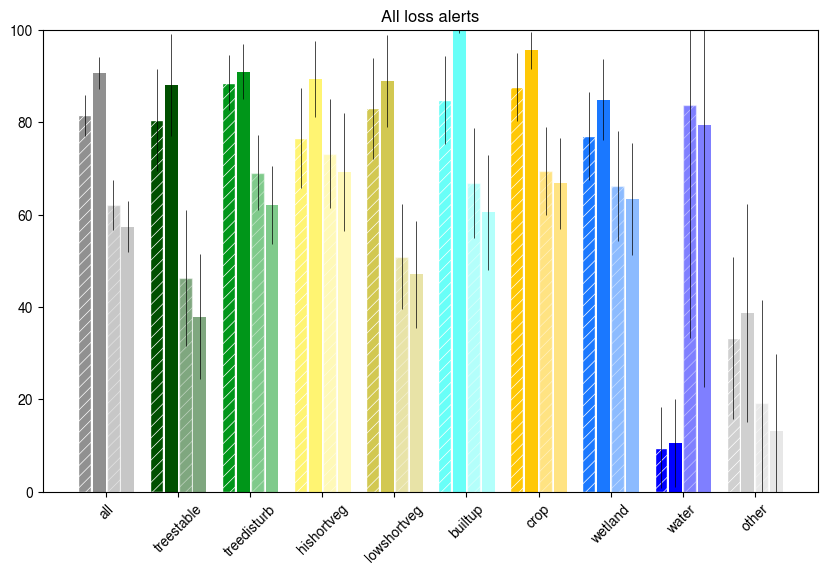

In [21]:
#accuracy 
import pandas as pd
import matplotlib
matplotlib.style.use('default')
palette = ["#68fff8","#005000","#009619","#ffc806","#1A78FF","#fff472","#d2c851","#d0d0d0","#0000ff","#909090"]
palette = [palette[9],palette[1],palette[2],palette[5],palette[6],palette[0],palette[3],palette[4],palette[8],palette[7]]

dfU = pd.DataFrame(U.values())
dfUSE = pd.DataFrame(USE.values())
dfP = pd.DataFrame(P.values())
dfPSE = pd.DataFrame(PSE.values())

df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","water","all"],
                   U["provconflow"],
                   USE["provconflow"],
                   U["conflow"],
                   USE["conflow"],
                   P["provconflow"],
                   PSE["provconflow"],
                   P["conflow"],
                   PSE["conflow"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersSE","usersconf","usersconfSE","prod","prodSE","prodconf","prodconfSE"]

strats = ["all","treestable","treedisturb","hishortveg","lowshortveg","builtup","crop","wetland","water","other"]
df = df.iloc[[9,1,2,5,6,0,3,4,8,7]]
df.to_csv('accuracyLow_water.csv', index=False)

x = np.arange(len(strats))
width=0.2
#print(x)

fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['hatch.linewidth'] = 0.5
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=df["usersSE"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=df["usersconfSE"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=df["prodSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=df["prodconfSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("Low loss alerts")
plt.savefig("accuracyLC_low_Water.svg",bbox_inches='tight')
#fig.show()

df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","water","all"],
                   U["provconfhigh"],
                   USE["provconfhigh"],
                   U["confhigh"],
                   USE["confhigh"],
                   P["provconfhigh"],
                   PSE["provconfhigh"],
                   P["confhigh"],
                   PSE["confhigh"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersSE","usersconf","usersconfSE","prod","prodSE","prodconf","prodconfSE"]
df = df.iloc[[9,1,2,5,6,0,3,4,8,7]]
df.to_csv('accuracyHigh_water.csv', index=False)
x = np.arange(len(strats))
width=0.2
#print(x)

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=df["usersSE"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=df["usersconfSE"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=df["prodSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=df["prodconfSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("High loss alerts")
plt.savefig("accuracyLC_high_Water.svg",bbox_inches='tight')
#fig.show()


df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","water","all"],
                   U["provconfall"],
                   USE["provconfall"],
                   U["confall"],
                   USE["confall"],
                   P["provconfall"],
                   PSE["provconfall"],
                   P["confall"],
                   PSE["confall"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersSE","usersconf","usersconfSE","prod","prodSE","prodconf","prodconfSE"]
df = df.iloc[[9,1,2,5,6,0,3,4,8,7]]
df.to_csv('accuracyAll_water.csv', index=False)
x = np.arange(len(strats))
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=df["usersSE"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=df["usersconfSE"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=df["prodSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=df["prodconfSE"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("All loss alerts")
plt.savefig("accuracyLC_all_Water.svg",bbox_inches='tight')



## Calculate accuracy of GEN for thematic classes

In [22]:
mapGEN = getDISTALERTStatus_vI_GEN(True)

1323 OPERA_L3_DIST-ALERT-HLS_T19HFC_20230219T142709Z_20231221T042133Z_S2B_30_v1_VEG-DIST-STATUS,20230219,2023-12-21 04:21:33,,,,,,


In [24]:
print("Accuracy of GEN for detecting vegetation loss and other change")
accuraciesGEN = []
(n,ntotal,nout)=getMatrix(mapGEN,[2],[5],nodata=[1,3,7,4,6,8],refType="OCVL")
accuraciesGEN = accuraciesGEN + getAccuracies(n,ntotal, "prov",measure="users")

(n,ntotal,nout)=getMatrix(mapGEN,[2,3,7],[5,6,8],nodata=[1,4],refType="OCVL")
accuraciesGEN = accuraciesGEN + getAccuracies(n,ntotal, "provconf")

(n,ntotal,nout)=getMatrix(mapGEN,[3,7],[6,8],nodata=[1,2,4,5],refType="OCVL")
accuraciesGEN = accuraciesGEN + getAccuracies(n,ntotal, "conf")

(n,ntotal,nout)=getMatrix(mapGEN,[2,3,7],[5,6,8],nodata=[1,4],convOnly=True,only23=True,refType="OCVL")
accuraciesGEN = accuraciesGEN + getAccuracies(n,ntotal, "conversion",measure="producers")

accuraciesGEN = pd.DataFrame(accuraciesGEN,columns=["name","users","usersSE","producers","producersSE"])
accuraciesGEN = accuraciesGEN[["users","usersSE","producers","producersSE"]].set_index(accuraciesGEN.name)
print(accuraciesGEN)

Accuracy of GEN for detecting vegetation loss and other change
                   users  usersSE producers producersSE
name                                                   
prov_low         50.2287  8.73243        NA          NA
prov_high        55.6582  22.0052        NA          NA
prov_all         50.8797  8.12902        NA          NA
provconf_low     65.6574  6.26493   18.2487     5.51591
provconf_high    69.5409  9.20077    60.973     9.07579
provconf_all     66.6028  5.23826   23.8502      6.0246
conf_low         74.2602  6.54938   15.6084      4.9262
conf_high        74.4785  8.71375    58.517     9.14774
conf_all         74.3223  5.28594   21.2229      5.5277
conversion_low        NA       NA   15.7707     18.9289
conversion_high       NA       NA    61.219     23.1059
conversion_all        NA       NA   25.3957     17.0216


In [25]:
print("Accuracy of GEN for detecting other change (ref veg loss considered no-data)")

accuraciesGEN_OC = []
(n,ntotal,nout)=getMatrix(mapGEN,[2],[5],nodata=[1,3,7,4,6,8],refType="OConly")
accuraciesGEN_OC = accuraciesGEN_OC + getAccuracies(n,ntotal, "prov",measure="users")

(n,ntotal,nout)=getMatrix(mapGEN,[2,3,7],[5,6,8],nodata=[1,4],refType="OConly")
accuraciesGEN_OC = accuraciesGEN_OC + getAccuracies(n,ntotal, "provconf")

(n,ntotal,nout)=getMatrix(mapGEN,[3,7],[6,8],nodata=[1,2,4,5],refType="OConly")
accuraciesGEN_OC = accuraciesGEN_OC + getAccuracies(n,ntotal, "conf")

(n,ntotal,nout)=getMatrix(mapGEN,[2,3,7],[5,6,8],nodata=[1,4],convOnly=True,only23=True,refType="OConly")
accuraciesGEN_OC = accuraciesGEN_OC + getAccuracies(n,ntotal, "conversion",measure="producers")

accuraciesGEN_OC = pd.DataFrame(accuraciesGEN_OC,columns=["name","users","usersSE","producers","producersSE"])
accuraciesGEN_OC = accuraciesGEN_OC[["users","usersSE","producers","producersSE"]].set_index(accuraciesGEN_OC.name)
print(accuraciesGEN_OC)

Accuracy of GEN for detecting other change (ref veg loss considered no-data)
                   users  usersSE producers producersSE
name                                                   
prov_low         30.8846  8.85948        NA          NA
prov_high         24.322  21.3126        NA          NA
prov_all         30.1176  8.21042        NA          NA
provconf_low     40.0169  6.81128   22.0763     11.1954
provconf_high    44.4441  10.8688   67.3473     12.7737
provconf_all     41.0852   5.7965   26.4916     11.9478
conf_low         45.7537  7.90395   19.8811     10.2925
conf_high        48.5517  11.2292   65.4172     13.0441
conf_all          46.532  6.50236   24.2597     11.1451
conversion_low        NA       NA   96.8722     3.81994
conversion_high       NA       NA       NaN         NaN
conversion_all        NA       NA   96.8722     3.81994


In [23]:
print("Accuracy of GEN for detecting vegetation loss")
accuraciesGEN_VL = []
(n,ntotal,nout)=getMatrix(mapGEN,[2],[5],nodata=[1,3,7,4,6,8])
accuraciesGEN_VL = accuraciesGEN_VL + getAccuracies(n,ntotal, "prov",measure="users")

(n,ntotal,nout)=getMatrix(mapGEN,[2,3,7],[5,6,8],nodata=[1,4])
accuraciesGEN_VL = accuraciesGEN_VL + getAccuracies(n,ntotal, "provconf")

(n,ntotal,nout)=getMatrix(mapGEN,[3,7],[6,8],nodata=[1,2,4,5])
accuraciesGEN_VL = accuraciesGEN_VL + getAccuracies(n,ntotal, "conf")

(n,ntotal,nout)=getMatrix(mapGEN,[2,3,7],[5,6,8],nodata=[1,4],convOnly=True,only23=True)
accuraciesGEN_VL = accuraciesGEN_VL + getAccuracies(n,ntotal, "conversion",measure="producers")

accuraciesGEN_VL = pd.DataFrame(accuraciesGEN_VL,columns=["name","users","usersSE","producers","producersSE"])
accuraciesGEN_VL = accuraciesGEN_VL[["users","usersSE","producers","producersSE"]].set_index(accuraciesGEN_VL.name)
print(accuraciesGEN_VL)

Accuracy of GEN for detecting vegetation loss
                   users  usersSE producers producersSE
name                                                   
prov_low         24.5661  6.93273        NA          NA
prov_high        35.5887   20.744        NA          NA
prov_all         25.8906  6.59072        NA          NA
provconf_low      37.202  6.20994   18.1964     4.45461
provconf_high    31.7207  8.66237   59.0311     11.6758
provconf_all     35.8685   5.0896    24.901     4.28984
conf_low         42.8349  7.41655   15.3801     4.19599
conf_high        32.9135  9.12989    56.659     11.6947
conf_all         40.0177  5.86926   22.1872     4.11014
conversion_low        NA       NA   6.54253      12.817
conversion_high       NA       NA   61.2886     23.1226
conversion_all        NA       NA   19.1549     13.4326


## Timeliness

#### Functions

In [26]:
def getRefALERTDateDaily(yeslabels,nolabels,adjusted):
  refdate = {}
  deltalist = [ [] for s in range(Nstrata+1)]
  with open("referenceTimeSeriesInterpolated16.csv",'r') as mapfile:
    lines = mapfile.readlines()
    header = lines[0]
    reflist = lines[1:]
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype) = fields[0:5]
    daily = fields[5:]
    refdate[ID] = [-1 for i in range(0,365)]
    for day in range(0,365):
      found = False
      for l in yeslabels:
        if l == daily[day]:
          found = True
        #if l in daily[day] and int(ID) in refVLmaj:
        #  found = True
      if found:
        if day==0:
            refdate[ID][day] = 1
        elif refdate[ID][day-1]>0:
            refdate[ID][day] = refdate[ID][day-1]
        elif refdate[ID][day-1] == 0:
            refdate[ID][day] = day+1
        else:
            i=1
            while((day-i)>=0 and refdate[ID][day-i]==-1):#potentially could have loss nodat loss...
                i+=1
            if refdate[ID][day-i]>0:
                refdate[ID][day] = refdate[ID][day-i]
            else:
                deltalist[strata[ID]].append((i/2))
            if adjusted:
                refdate[ID][day] = (day-i/2)+1
            else:
                refdate[ID][day] = day+1
      else:
        for l in nolabels:
          if l == daily[day]:
            found = True
        if found:
          refdate[ID][day] = 0
        else:
          refdate[ID][day] = -1
  return (refdate,deltalist)

In [27]:
def getDISTALERTDate_vI(skipNodata,adjusted,ids=allIDs):
    mapdate = {}
    for ID in ids:
      if ID != "1323":
        mapdate[ID] = [-1 for i in range(0,366)]
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
        header = lines[0]
        maplist = lines[1:]
        for line in maplist:
            (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
            day = dayDiff("20230101",SensingTime)
            
            #if not (skipNodata and int(VEGANOM)==255):
            if VEGDISTSTATUS == '255' and mapdate[ID][day] == -1:
                mapdate[ID][day] = -1
                #print("status")
            elif skipNodata and VEGANOM=='255' and mapdate[ID][day] == -1:#VEGDISTDATE == "NA" and VEGIND==255:
                mapdate[ID][day] = -1
                #print("anom")
            elif VEGDISTDATE == 'NA':
                mapdate[ID][day] = 0
                #print("NA")
            else:
                if adjusted:
                    i=1
                    while((day-i)>=1 and mapdate[ID][day-i]==-1):
                       i+=1
                    if day-1>=1:
                        if mapdate[ID][day-i] == 0:
                            mapdate[ID][day] = (day-i/2)
                        else:
                            mapdate[ID][day] = mapdate[ID][day-i]#dayDiff("20211001",VEGDISTDATE)
                    else:
                        mapdate[ID][day-i] == dayDiff("20230101",VEGDISTDATE)/2
                else:
                    mapdate[ID][day] = dayDiff("20230101",VEGDISTDATE)
                    #print("day",dayDiff("20230101",VEGDISTDATE))
            
    return mapdate

In [28]:
def filterMap(map,cat):
    mapout = {}

    if cat == "lt50":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = [7,8]
    elif cat == "lt50_curr":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = []
    elif cat == "provlt50":
        nodist = [0]
        dist = [2,3,5,6]
        old = [7,8]
    elif cat == "lt50_onlyprov":
        nodist = [0]
        dist = [2,5]
        old = []
    elif cat == "onlylt50":
        nodist = [0]
        dist = [1,2,3]
        old = [7]
    elif cat == "confonlylt50":
        nodist = [0]
        dist = [3]
        old = [7]
    elif cat == "provonlylt50":
        nodist = [0]
        dist = [2,3]
        old = [7]
    elif cat == "onlylt50_onlyprov":
        nodist = [0]
        dist = [2]
        old = []
    elif cat == "gt50":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = [8]
    elif cat == "gt50_curr":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = []
    elif cat == "provgt50":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = [8]
    elif cat == "gt50_onlyprov":
        nodist = [0,1,2,3,7]
        dist = [5]
        old = []
    elif cat == "confgt50":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = [8]
    elif cat == "provgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = []  
    elif cat == "confgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = []
    elif cat == "conflt50":
        nodist = [0]
        dist = [3,6]
        old = [7,8]
    elif cat == "conflt50_curr":
        nodist = [0]
        dist = [3,6]
        old = []
    else:
        print(cat, "not found")
    for ID in allIDs:
        mapout[ID] = [0 for x in range(0,366)]
        for d in range(0,366):
            if map[ID][d] in nodist:
                mapout[ID][d] = 1
            elif map[ID][d] in dist:   
                mapout[ID][d] = 2
            elif map[ID][d] in old:
                mapout[ID][d] = 3
            else:
                mapout[ID][d] = 0
    return mapout

In [29]:
def getMean(deltalist):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in allStrata])
    
    denom = 0
    deltaSum = 0
    variance = 0
    for s in allStrata:
        scount = len(deltalist[s])
        if scount>0:
            smean = sum(deltalist[s])/scount
            if scount > 1:
                ssum = 0
                for i in deltalist[s]:
                    ssum += (i-smean)**2
                sv = (1/(scount-1))*ssum
                variance += (N[str(s)]/Ntotal)**2 * ((N[str(s)]-scount)/(N[str(s)]-1)) * sv/scount
                #variance += (N[str(s)])**2 * ((N[str(s)]-aCount[s])/(N[str(s)]-1)) * sv/aCount[s]
                #print(s,aCount[s],smean,math.sqrt(sv))
            
            denom += (scount * (N[str(s)]))
            deltaSum += smean * (scount * (N[str(s)]))
            
    sampleMean = deltaSum/denom
    SE = math.sqrt(variance)
            
    return (sampleMean,SE)#,deltaDate)

In [30]:
def estimateDetectionLag(cat,map,ref,mapdate,refdate,strataCounts,mincount,excludelist,Ndays,ids=allIDs):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in allStrata])
    ndeltaSum = [0 for s in range(Nstrata+1)]
    nCount = [0 for s in range(Nstrata+1)]
    aCount = [0 for s in range(Nstrata+1)]
    deltaList = [ [] for s in range(Nstrata+1)]

    deltaDate = {}
    for ID in ids:
      if ID != '1323':
        atotal = 0
        deltaTotal = 0
        deltaDate[ID] = [-1 for i in range(0,365)]
        for d in range(0,365):
            if not int(ID) in excludelist:
                if max(ref[ID][0:(d+1)])>0:
                    start = (d>Ndays)*(d-Ndays)
                    if map[ID][d] == 2:#active alert
                        if ref[ID][start:(d+mincount)].count(2) > mincount:#if ref also has alert
                            i=0
                            while(refdate[ID][d-i]<=0):#go back to first ref date with date
                                i+=1
                            deltaDate[ID][d] = mapdate[ID][d]-refdate[ID][d-i]
                            
                            if deltaDate[ID][d]<0:
                                deltaDate[ID][d] = 0
                            deltaTotal +=deltaDate[ID][d] #sum total delta
                            atotal += 1 #count total dates of alert

        if atotal>0: # if alert dates
            aCount[strata[ID]] += 1 # add count of alert pixels to strata
            ndeltaSum[strata[ID]] += (deltaTotal/atotal) #average delta for pixel
            deltaList[strata[ID]].append(deltaTotal/atotal) # append average delta to strata list
        
    (sampleMean,SE) = getMean(deltaList)
    
    return (sampleMean,SE)#,deltaDate)

In [31]:
def printDictionary(dict,name):
    with open(name,'w') as OUT:
        for i in dict.keys():
            days = dict[i]
            OUT.write(i+","+','.join(str(x) for x in days)+"\n")

In [34]:
def alertConfusionMatrix_lag_low_high(mapF,maplow,maphigh,ref,mincount=10,Ndays=30,IDlist=allIDs,excludelist=[]):
  mapout = {}
  N = strataCounts
  n = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in allStrata}
  ntotal = {s:0 for s in allStrata}
  
  #confusion matrix
  for ID in IDlist:
    try:
      p = [[0,0,0],[0,0,0],[0,0,0]]
      ptotal = 0
      mapout[ID] = [0 for x in range(0,366)]
      for d in range(0,366):
        if mapF[ID][d] in [0]:
            mapout[ID][d] = 1
        elif mapF[ID][d] in maplow:#[2,3,7]: #1 first excluded  
            mapout[ID][d] = 2
        elif mapF[ID][d] in maphigh:#[5,6,8]:#4 first excluded
            mapout[ID][d] = 3
        elif mapF[ID][d] in [255]:#4 first excluded
            mapout[ID][d] = 0
        #else:############added to exclude fron natrix but include in proportion
        #    mapout[ID][d] = 4
        if not int(ID) in excludelist:
          if max(ref[ID][0:(d+1)])>0 and mapout[ID][d] != 0:
              refVal = ref[ID][d]
              mapVal = mapout[ID][d]
              if mapVal==4 and refVal>0:
                ptotal += 1
              elif refVal>0 and mapVal>0:
                  p[refVal-1][mapVal-1] += 1
                  ptotal += 1
      if ptotal>0:
        ntotal[strata[ID]] += 1
        for r in [0,1,2]:
          for m in [0,1,2]:
            n[strata[ID]][r][m] += (p[r][m]/ptotal)
    except:
      error =1

  return (n,ntotal)

In [35]:
def usersSkipND(maplow,maphigh,name,duration=10, lookback=30,convOnly=False,only23=False):
    basename = name
    mapdate = getDISTALERTDate_vI(True,False)
    name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
    print(name, "\n")
    userslowND = []; 
    usershighND = []; 
    ref = getRefALERTDaily("referenceTimeSeriesInterpolated16.csv",conversiononly=convOnly,only2023=only23)
    for lagx in range(0,61):
        #print(lagx)
        mapFiltered = {}
        for ID in mapdate.keys():
          mapFiltered[ID] = [0 for d in range(0,366)]
          if ID != '1323':
            for d in range(0,366):
                #set out map to input map
                mapFiltered[ID][d]=map[ID][d]

                #if the current date is longer the evaluated lag from the detection date and the map is alert, set to no data
                if (d - (mapdate[ID][d]-1))>lagx and (map[ID][d]>=1 and map[ID][d]!=255):
                    mapFiltered[ID][d] = 255

                #else if there is a alert date within the lag, evaluate from the date out to the length of the lag
                elif mapdate[ID][d] > 0 and (map[ID][d]>=1 and map[ID][d]!=255):
                    last = min(mapdate[ID][d]-1+lagx,365)
                    mapVal = 255
                    #set the most recent alert value
                    for x in range(mapdate[ID][d]-1,last):
                        if map[ID][x] !=255:
                            mapVal = map[ID][x] 
                    #if the last value is nodisturbance, set all prior alerts to nodata
                    if mapVal == 0:
                        for x in range(mapdate[ID][d]-1,last):
                            if map[ID][x] >0:
                                mapFiltered[ID][x]=255
        (n,ntotal) = alertConfusionMatrix_lag_low_high(mapFiltered,maplow,maphigh,ref,Ndays=duration,mincount=lookback)
        (nlowuser, t1, nhiuser,t2, t3, t4)=convMat(n)
        userslowND.append(usersAccuracy(nlowuser,ntotal,name+"_low"))
        usershighND.append(usersAccuracy(nhiuser,ntotal,name+"_high"))
    return (userslowND,usershighND)


In [36]:
def producersSkipND(maplow,maphigh,name,duration=10, lookback=30,convOnly=False,only23=False):
    basename = name
    name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
    ref = getRefALERTDaily("referenceTimeSeriesInterpolated16.csv",conversiononly=convOnly,only2023=only23)
    (refdate,refuncList) = getRefALERTDateDaily(["VLmin","VLmaj","VLtotal"],["OCmin","OCmaj","OCtotal","noChange"],False)
    (refdatehigh,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal"],["VLmin","OCmin","OCmaj","OCtotal","noChange"],False)

    print(name, "\n")
    producerslowND = []
    producershighND = []
    for lagx in range(0,63):
        refFiltered = {}
        refFilteredLow = {}
        refFilteredHigh = {}
        for ID in allIDs:
            refFiltered[ID] = [0 for d in range(0,365)]
            refFilteredLow[ID] = [0 for d in range(0,365)]
            refFilteredHigh[ID] = [0 for d in range(0,365)]
            for d in range(0,365):
                start = (d>lookback)*(d-lookback)
                if (ref[ID][start:(d+duration)].count(2) + ref[ID][start:(d+duration)].count(3)) > duration:
                    #if ref[ID][start:d+1].count(3) > duration:
                    #  refFiltered[ID][d]=3
                    #else:
                    refFiltered[ID][d]=ref[ID][d]
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refFiltered[ID][d]=1
                else:
                    refFiltered[ID][d]=0
            for d in range(0,365):
                #if there was reference change and the current date is longer than the lag from the start date set to nodata
                refFilteredLow[ID][d] = refFiltered[ID][d]
                refFilteredHigh[ID][d] = refFiltered[ID][d]
                if (d - refdate[ID][d])>lagx and refFiltered[ID][d]>=2:
                    refFilteredLow[ID][d] =0
                if (d - refdatehigh[ID][d])>lagx and refFiltered[ID][d]==3:
                    refFilteredHigh[ID][d] =0
        (n,ntotal) = alertConfusionMatrix_lag_low_high(map,maplow,maphigh,refFilteredLow,Ndays=duration,mincount=lookback)
        (t1, nlowprod, t3, nhiprod,t5,t6)=convMat(n)
        producerslowND.append(producersAccuracy(nlowprod,ntotal,name))

        (n,ntotal) = alertConfusionMatrix_lag_low_high(map,maplow,maphigh,refFilteredHigh,Ndays=duration,mincount=lookback)
        (t2,t2,t3, nhiprod,t5,t6)=convMat(n)
        producershighND.append(producersAccuracy(nhiprod,ntotal,name))
    return (producerslowND, producershighND)

#### Latency

In [32]:
map = getDISTALERTStatus_vI(True)
mapNoSkipND = getDISTALERTStatus_vI(False)

1323 OPERA_L3_DIST-ALERT-HLS_T19HFC_20230219T142709Z_20231221T042133Z_S2B_30_v1_VEG-DIST-STATUS,20230219,2023-12-21 04:21:33,,,,,,
1323 OPERA_L3_DIST-ALERT-HLS_T19HFC_20230219T142709Z_20231221T042133Z_S2B_30_v1_VEG-DIST-STATUS,20230219,2023-12-21 04:21:33,,,,,,


In [33]:
mapsource = "mapLabels2023"
mapdate_skipND = getDISTALERTDate_vI(True,False)
printDictionary(mapdate_skipND,"mapv1_date_skipND.csv")
mapdate = getDISTALERTDate_vI(False,False)
printDictionary(mapdate,"mapv1_date.csv")
for cattype in ["lt50","gt50"]:
    print()
    basename = cattype
    mapsimple = filterMap(map,cattype)
    for refAdj in [True,False]:
        for duration in [10]:#,5,10,15]:
            for lookback in [30]:#1,15,30]:
                name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
                noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
                #ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels,IDlist=allIDs)
                ref = getRefALERTbinaryDaily("referenceTimeSeries.csv",["VLmaj","VLtotal","VLmin"],noLabels,IDlist=allIDs)
                (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,refAdj)
                (refunc,ruSE) = getMean(refuncList)
                (lag,SE) = estimateDetectionLag(cattype,mapsimple,ref,mapdate_skipND,refdate,strataCounts,duration,[],lookback)
                printDictionary(refdate,"refdate_"+name+"adj"+str(refAdj)+".csv")
                print("Skip no new data dates",name, round(lag,2),"+/-",round(SE,2),"day mean lag,",round(refunc,2),"+/-",round(ruSE,2),"day mean uncertainty in the reference data, reference adjusted",refAdj)

    mapsimple = filterMap(mapNoSkipND,cattype)
    for refAdj in [True,False]:
        for duration in [10]:#,5,10,15]:
            for lookback in [30]:#1,15,30]:
                name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
                noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
                ref = getRefALERTbinaryDaily("referenceTimeSeries.csv",["VLmaj","VLtotal","VLmin"],noLabels,IDlist=allIDs)
                (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,refAdj)
                (refunc,ruSE) = getMean(refuncList)
                (lag,SE) = estimateDetectionLag(cattype,mapsimple,ref,mapdate,refdate,strataCounts,duration,[],lookback)
                printDictionary(refdate,"refdate_"+name+"adj"+str(refAdj)+".csv")
                print("All granule dates",name, round(lag,2),"+/-",round(SE,2),"day mean lag,",round(refunc,2),"+/-",round(ruSE,2),"day mean uncertainty in the reference data, reference adjusted",refAdj)


Skip no new data dates lt50_lookback30_duration10_VLmin 19.52 +/- 0.38 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data, reference adjusted True
Skip no new data dates lt50_lookback30_duration10_VLmin 15.52 +/- 0.35 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data, reference adjusted False
All granule dates lt50_lookback30_duration10_VLmin 18.96 +/- 0.51 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data, reference adjusted True
All granule dates lt50_lookback30_duration10_VLmin 15.05 +/- 0.48 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data, reference adjusted False

Skip no new data dates gt50_lookback30_duration10_VLmin 9.86 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data, reference adjusted True
Skip no new data dates gt50_lookback30_duration10_VLmin 6.19 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data, reference adjusted False
All g

#### Accuracy per time lag

In [37]:
(userslowND,usershighND) = usersSkipND([2,3],[5,6],"provconf")
#(userslowNDFirst,usershighNDFirst) = usersSkipND([1,2,3],[4,5,6],"first")

provconf_lookback30_duration10 



In [38]:
(producerslowND, producershighND) = producersSkipND([2,3],[5,6],"provconf")
#(producerslowNDFirst, producershighNDFirst) = producersSkipND([1,2,3],[4,5,6],"first")

provconf_lookback30_duration10 



/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


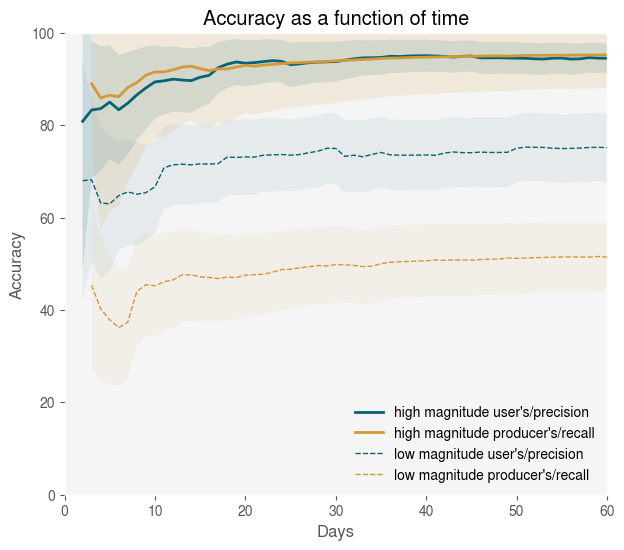

In [39]:
import matplotlib
matplotlib.style.use('ggplot')

userslow = userslowND
usershigh = usershighND
producerslow = producerslowND
producershigh = producershighND

#userslow = userslowNDFirst
#usershigh = usershighNDFirst
#producerslow = producerslowNDFirst
#producershigh = producershighNDFirst


endindex = 61
xu = range(0,endindex)
xp = range(3,endindex+3)
plt.figure(figsize=(7,6))
pal = ["#D49937","#2E7B8A"]
pal = ["#066274","#D49937"]#,"#2E7B8A"]
#pal = ["#066274","#74A57F"]#"#598863"]
yulow = np.array([row[0] for row in userslow[0:endindex]])
yulowerr = np.array([row[1] for row in userslow[0:endindex]])
yuhigh = np.array([row[0] for row in usershigh[0:endindex]])
yuhigherr = np.array([row[1] for row in usershigh[0:endindex]])
yplow = np.array([row[0] for row in producerslow[0:endindex]])
yplowerr = np.array([row[1] for row in producerslow[0:endindex]])
yphigh = np.array([row[0] for row in producershigh[0:endindex]])
yphigherr = np.array([row[1] for row in producershigh[0:endindex]])
#print(yuhigh)
#print(yphigh)
data = np.vstack([yulow,yulowerr,yuhigh,yuhigherr,yplow,yplowerr,yphigh,yphigherr])
pd.DataFrame(data).to_csv("accuracyTime.csv")
labs = ['Users: >=50, VLmin','Producers: <50, VLmin']

plt.fill_between(xu, yulow-yulowerr, yulow+yulowerr,facecolor=pal[0]+'11',linewidth=0.1)
plt.fill_between(xu, yuhigh-yuhigherr, yuhigh+yuhigherr,facecolor=pal[0]+'22',linewidth=0.1)
plt.fill_between(xp, yplow-yplowerr, yplow+yplowerr,facecolor=pal[1]+'11',linewidth=0.1)
plt.fill_between(xp, yphigh-yphigherr, yphigh+yphigherr,facecolor=pal[1]+'22',linewidth=0.1)
plt.plot(xu,yuhigh,color=pal[0],label='high magnitude user\'s/precision',linewidth=2)
plt.plot(xp,yphigh,color=pal[1],label='high magnitude producer\'s/recall',linewidth=2)
plt.plot(xu,yulow,color=pal[0],label='low magnitude user\'s/precision', linestyle='--',linewidth=1)
plt.plot(xp,yplow,color=pal[1],label='low magnitude producer\'s/recall', linestyle='--',linewidth=1)
leg2 = plt.legend(reversed(labs),bbox_to_anchor=(1.04,1),loc='upper left',framealpha=0)
plt.setp(leg2.get_texts(), color='#444444')
plt.legend(loc='lower right',framealpha=0)
plt.ylim(0,100)
plt.xlim(0,60)
plt.title('Accuracy as a function of time')# excluding dates with no new observation')
plt.ylabel('Accuracy')#²')
plt.xlabel('Days')#²')
plt.grid(False)
plt.axes().set_facecolor("#f5f5f5")
plt.savefig("accuracyTimeExcludeNoData.svg",bbox_inches='tight')#, format='pdf')
plt.show()

## DIST-ANN accuracy

#### Functions

In [40]:
def getDISTANNbinary(yes,nodata,threshold=False):
  with open(mapsource + '/All_DIST-ANN_'+ANNname+'.csv','r') as mapfile:
    maplist = mapfile.readlines()[1:]
  mapann = {}
  for line in maplist:
    (ID,Stratum,Long,Lat,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_IND_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_DUR,VEG_DIST_COUNT,GEN_DIST_STATUS,GEN_ANOM_MAX,GEN_DIST_CONF,GEN_DIST_DATE,GEN_DIST_DUR,GEN_DIST_COUNT) = line.strip().split(',')
    if not threshold:
      if int(VEG_DIST_STATUS) in yes:
        mapann[ID] = 2
      elif int(VEG_DIST_STATUS) in nodata:
        mapann[ID] = 0
      else:
        mapann[ID] = 1
    else:
      if int(VEG_DIST_STATUS) in yes and int(VEG_ANOM_MAX) >= threshold:
        mapann[ID] = 2
      elif int(VEG_DIST_STATUS) in nodata:
        mapann[ID] = 0
      else:
        mapann[ID] = 1
  return mapann

In [41]:
def getRefANNbinaryFilterDaily(yeslabels,maybelabels,yesmincount,maybemincount):
  with open('referenceTimeSeriesInterpolated16.csv','r') as reffile:
    reflist = reffile.readlines()[1:]
  refann = {}
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype)=fields[0:5]
    labels = fields[5:]
    yescount = 0
    maybecount = 0
    datacount = 0
    first = 0
    for l in labels:
      if l != "noObs" and first == 0:
        first = l
      if l in yeslabels:
        yescount +=1
      elif l in maybelabels:
        maybecount +=1
      if l != "noObs":
        datacount +=1
    if yescount >= yesmincount or maybecount >=maybemincount:# and not first in yeslabels:
      refann[ID] = 2
    elif datacount >= 1:
      refann[ID] = 1
    else:
      refann[ID] = 0
  return refann

#def getRefANNbinary(yeslabels,maybelabels,yesmincount,maybemincount):
#  with open('referenceTimeSeriesInterpolated16.csv','r') as reffile:
#    reflist = reffile.readlines()[1:]
#  refann = {}
#  for line in reflist:
#    fields = line.strip().split(',')
#    (ID,overallLabel,Long,Lat,changetype)=fields[0:5]
#    labels = fields[5:]
#    yescount = 0
#    maybecount = 0
#    datacount = 0
#    first = 0
#    for l in labels:
#      if l != "noObs" and first == 0:
#        first = l
#      if l in yeslabels:
#        yescount +=1
#      elif l in maybelabels:
#        maybecount +=1
#      if l != "noObs":
#        datacount +=1
#    if yescount >= yesmincount or maybecount >=maybemincount:# and not first in yeslabels:
#      refann[ID] = 2
#    elif datacount >= 1:
#      refann[ID] = 1
#    else:
#      refann[ID] = 0
#  return refann

In [42]:
def annualConfusionMatrix(map,ref,strataCounts,excludelist=[0],printMatrix = False):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in allStrata])
  #print("Total pixels:", Ntotal," Nstrata:",Nstrata)
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]
  #print(excludelist)
  refVLmaj = []
  #confusion matrix
  for ID in allIDs:
    if int(ID) in refVLmaj:
      ref[ID] = 2
    n[strata[ID]][int(ref[ID])][int(map[ID])] += 1
    if ref[ID] >0 and map[ID]>0:
      ntotal[strata[ID]] += 1
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          print(n[s][r][m],end=",")
      print()
  return (n,ntotal)

In [43]:
def getDISTANN_new(file,yes,nodata):
  with open(file+'.csv','r') as mapfile:
    maplist = mapfile.readlines()[1:]
  mapann = {}
  for line in maplist:
    (ID,Stratum,Long,Lat,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_COUNT,VEG_DIST_DUR,VEG_HIST,VEG_IND_MAX,VEG_CONF_COUNT,VEG_CONF_PREV,VEG_LAST_DATE,GEN_DIST_STATUS,GEN_ANOM_MAX,GEN_DIST_CONF,GEN_DIST_DATE,GEN_DIST_COUNT,GEN_DIST_DUR,GEN_CONF_COUNT,GEN_CONF_PREV,GEN_LAST_DATE) = line.strip().split(',')
    #(temp,ID,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_COUNT,VEG_DIST_DUR,VEG_HIST,VEG_IND_MAX) = line.strip().split(',')
    if int(VEG_DIST_STATUS) in yes:
       mapann[ID] = 2
    elif int(VEG_DIST_STATUS) in nodata:
       mapann[ID] = 0
    else:
       mapann[ID] = 1
  return mapann

In [44]:
def accuracy(n, ntotal, strataCounts,name,write=True):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in allStrata])

  #Accuracy
  overall = 0
  y = 0
  usersx = 0
  producersx = 0
  OAsub = 0
  area = [[0,0],[0,0]]
  for s in allStrata:
    #overall
    overall += ((n[s][1][1] + n[s][2][2])/ntotal[s])*(N[str(s)]/Ntotal)
    oyhmean = (n[s][1][1] + n[s][2][2])/ntotal[s]
    sampvaryhOA = ((n[s][1][1] + n[s][2][2])*((1-oyhmean)**2) + (n[s][1][2] + n[s][2][1])*((0-oyhmean)**2))/(ntotal[s]-1)
    OAsub += N[str(s)]*N[str(s)]*(1-ntotal[s]/N[str(s)])*sampvaryhOA/(ntotal[s])*(1/Ntotal**2)

    #users and producers
    y += (n[s][2][2]/ntotal[s])*N[str(s)]
    usersx += ((n[s][1][2]+n[s][2][2])/ntotal[s])*N[str(s)]
    producersx += ((n[s][2][1]+n[s][2][2])/ntotal[s])*N[str(s)]
    
    #print("strata",s,n[s][1][1],n[s][1][2],n[s][2][1],n[s][2][2])
    for i in range(1,3):
      for j in range(1,3):
        area[i-1][j-1] += (n[s][i][j]/ntotal[s])*(N[str(s)]/Ntotal)
  
  #print(area[0][0]*100,area[0][1]*100)
  #print(area[1][0]*100,area[1][1]*100)

  overall = overall*100
  overallSE = math.sqrt(OAsub)*100
  if usersx > 0:
    users = (y/usersx)
  else:
    users = "NA"
    usersSE = "NA"
  if producersx > 0:
    producers = (y/producersx)
  else:
    producers = "NA"
    producersSE = "NA"

  UAsub1 = 0
  UAsub2 = 0
  PAsub1 = 0
  PAsub2 = 0
  for s in allStrata:
    #users and producers
    yhmean = n[s][2][2]/ntotal[s]
    yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
    
    if users != "NA":
        if (n[s][1][2]+n[s][2][2]) > 0:
            xuhmean = (n[s][1][2]+n[s][2][2])/ntotal[s]
            xuhsampvar = ((n[s][1][2]+n[s][2][2])*((1-xuhmean)**2) + (n[s][1][1] + n[s][2][1])*((0-xuhmean)**2))/(ntotal[s]-1)
            xyuhsampvar = (n[s][1][1] * (0-yhmean) * (0-xuhmean) + n[s][1][2] * (0-yhmean) * (1-xuhmean) + n[s][2][1] * (0-yhmean) * (0-xuhmean) + n[s][2][2] * (1-yhmean) * (1-xuhmean))/(ntotal[s] - 1)
            UAsub1 += N[str(s)]*xuhmean
            UAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (users**2)*xuhsampvar - 2*users*xyuhsampvar)/ntotal[s]
    
    if producers != "NA":
        if (n[s][2][1]+n[s][2][2]) > 0:
            xphmean = (n[s][2][1]+n[s][2][2])/ntotal[s]
            xphsampvar = ((n[s][2][1]+n[s][2][2])*((1-xphmean)**2) + (n[s][1][1] + n[s][1][2])*((0-xphmean)**2))/(ntotal[s]-1)
            xyphsampvar = (n[s][1][1] * (0-yhmean) * (0-xphmean) + n[s][1][2] * (0-yhmean) * (0-xphmean) + n[s][2][1] * (0-yhmean) * (1-xphmean) + n[s][2][2] * (1-yhmean) * (1-xphmean))/(ntotal[s] - 1)
            PAsub1 += N[str(s)]*xphmean
            PAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (producers**2)*xphsampvar - 2*producers*xyphsampvar)/ntotal[s]

  
  if users != "NA":
    usersSE = math.sqrt(1/(UAsub1**2) * UAsub2) * 100
    users = users*100
  else:
    usersSE = "NA"
  if producers != "NA":
    if PAsub1>0 and PAsub2 > 0:
      producersSE = math.sqrt(1/(PAsub1**2) * PAsub2) * 100
    else:
      producersSE = "NA"
    producers = producers*100
  else:
    producersSE = "NA"
  print("Overall:",overall," +-", overallSE)
  print("Users:",users," +-", usersSE)
  print("Producers:",producers," +-", producersSE)
  if write:
    with open("accuracy.csv",'a') as OUT:
        OUT.write(','.join([name,str(overall),str(overallSE),str(users),str(usersSE),str(producers),str(producersSE)])+"\n")

#### Calculation

In [45]:
#ANN
file = mapsource+"/All_DIST-ANN_2023"
basename = "DIST-ANN_v1"
durlist = [10,35,75]
for duration in durlist:
    name = basename+"_dur"+str(duration)+"_gt50"
    print("\n"+name)
    map = getDISTANN_new(file,[6,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj"],["VLmin"],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)
    #print(producersAccuracy(n, ntotal, name))
    
for duration in durlist:
    name = basename+"_dur"+str(duration)+"_lt50"
    print("\n"+name)
    map = getDISTANN_new(file,[3,6,7,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj"],["VLmin"],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)
    
for duration in durlist:

    name = basename+"_dur"+str(duration)+"_gt50"+"_VLmin"
    print("\n"+name)
    map = getDISTANN_new(file,[6,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj","VLmin"],[],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)
    
for duration in durlist:

    name = basename+"_dur"+str(duration)+"_lt50"+"_VLmin"
    print("\n"+name)
    map = getDISTANN_new(file,[3,6,7,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj","VLmin"],[],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)


DIST-ANN_v1_dur10_gt50
Overall: 98.9328236274941  +- 0.17944035786358895
Users: 60.30204718021738  +- 3.622584146653259
Producers: 43.61856407797063  +- 6.38428256828361

DIST-ANN_v1_dur35_gt50
Overall: 99.27116616804675  +- 0.08293963882877996
Users: 35.713653998451676  +- 3.367077441940849
Producers: 68.98090881964693  +- 11.311116924753572

DIST-ANN_v1_dur75_gt50
Overall: 99.15129672567853  +- 0.03886429029885965
Users: 10.921561841923014  +- 1.8769516212275972
Producers: 70.90380628990334  +- 14.03429642793212

DIST-ANN_v1_dur10_lt50
Overall: 96.93643058834567  +- 0.26435082097418133
Users: 24.99305911377665  +- 3.215763835451002
Producers: 72.10403250500032  +- 8.371608241419139

DIST-ANN_v1_dur35_lt50
Overall: 96.8466740424477  +- 0.24250733618628798
Users: 12.911830523549462  +- 2.2539422548964048
Producers: 99.46797378064703  +- 0.2801633012914026

DIST-ANN_v1_dur75_lt50
Overall: 96.52175283992479  +- 0.24592162334829004
Users: 3.86201868260349  +- 0.8979912348291079
Producers